# Bayesian Global Optimization in Convolutional Neural Network

## Read SVHN Dataset

In [1]:
from scipy.io import loadmat
x = loadmat('svhn_data/train_32x32.mat')
y = loadmat('svhn_data/test_32x32.mat')
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
train_labels = x['y']

In [3]:
train_features = np.swapaxes(np.swapaxes(np.swapaxes(x['X'],2,3), 1,2), 0,1)

In [4]:
test_labels = y['y']

In [5]:
test_features = np.swapaxes(np.swapaxes(np.swapaxes(y['X'],2,3), 1,2), 0,1)

In [6]:
def display_image(position):
    image = train_features[position, :, : ,:].squeeze()
    plt.title('Example %d. Label: %d' % (position, train_labels[position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

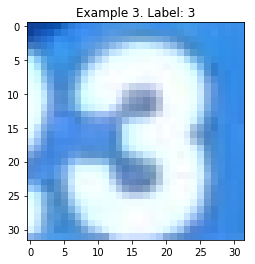

In [7]:
display_image(3)

In [8]:
del x, y

## Explore Dataset

In [9]:
train_labels_count = np.unique(train_labels, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,1,13861
1,2,10585
2,3,8497
3,4,7458
4,5,6882
5,6,5727
6,7,5595
7,8,5045
8,9,4659
9,10,4948


## Train Test Split

In [10]:
validation = {}
train_features, validation_features, train_labels, validation_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=0)

In [11]:
train_labels.shape

(58605, 1)

In [12]:
print('# of training images:', train_features.shape[0])
print('# of validation images:', validation_features.shape[0])

# of training images: 58605
# of validation images: 14652


## Create sample model

#### Hyperparameters to experiment with

Implement Bayesian Global Optimization to arrive at optimal hyper parameter values for:
1. Starting Learning Rate $\eta_0$
2. Learning Rate Decay $\delta$ where learning-rate $\eta = \frac{\eta_0}{(1+\delta*t)}$ 
3. Mini-batch size: $B$
4. Dropout parameter $p_1$ for first fully connected layer
5. Dropout parameter $p_2$ for second fully connected layer

In [13]:
# STARTING_LEARNING_RATE = 0.001
# DECAY = 0.0000001
# BATCH_SIZE = 256
# DROPOUT_P1 = 0.001
# DROPOUT_P2 = 0.001
#EPOCHS = 1

In [14]:
# STARTING_LEARNING_RATE = [0.001,0.01,0.05,0.1]
# DECAY = [0.0000001,0.000001,0.0001]
# # BATCH_SIZE = [32, 64, 128] #256,512,1024]
# BATCH_SIZE = [256,512,1024]
# DROPOUT_P1 = [0.1,0.25,0.5]
# DROPOUT_P2 = [0.1,0.25,0.5]
# EPOCHS = 1

STARTING_LEARNING_RATE = [0.001,0.01]
DECAY = [0.0000001,0.00001]
# BATCH_SIZE = [32, 64, 128] #256,512,1024]
BATCH_SIZE = [256,512]
DROPOUT_P1 = [0.1, 0.4]
DROPOUT_P2 = [0.1, 0.4]
EPOCHS = 1

In [15]:
X_train, y_train = train_features, to_categorical(train_labels)[:,1:]
# X_train = train_features
X_validation, y_validation = validation_features, to_categorical(validation_labels)[:,1:]

#Comment when running Grid Search
#train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
#validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [ ]:
############# LENET #############
# model = keras.Sequential()

# model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
# model.add(layers.AveragePooling2D())

# model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
# model.add(layers.AveragePooling2D())

# model.add(layers.Flatten())

# model.add(layers.Dense(units=120, activation='relu'))

# model.add(layers.Dense(units=84, activation='relu'))

# model.add(layers.Dense(units=10, activation = 'softmax'))
# #, kernel_initializer="glorot_uniform", bias_initializer="zeros")


############# Proposed Model #############
# model = keras.Sequential()
# model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3), strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
# #model.add(layers.AveragePooling2D())

# model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
# #model.add(layers.AveragePooling2D())
# model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))

# model.add(layers.Flatten())

# model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
# model.add(layers.Dropout(rate=DROPOUT_P1, seed=1))
# model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
# model.add(layers.Dropout(rate=DROPOUT_P2, seed=1))
# model.add(layers.Dense(units=10, activation = 'softmax'))


############# Grid Search #############
result=[]
for lr in STARTING_LEARNING_RATE:
    for b in BATCH_SIZE:
        for dec in DECAY:
            for d1 in DROPOUT_P1:
                for d2 in DROPOUT_P2:
                    
                    print(lr, b, dec, d1, d2)
                    
                    train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=b)
                    validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=b)

                    model = keras.Sequential()
                    model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3), strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
                    model.add(layers.AveragePooling2D())

                    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
                    model.add(layers.AveragePooling2D())
                    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))

                    model.add(layers.Flatten())

                    model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
                    model.add(layers.Dropout(rate=d1, seed=10))
                    model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
                    model.add(layers.Dropout(rate=d2, seed=10))
                    model.add(layers.Dense(units=10, activation = 'softmax'))
                    
                    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=lr,decay=dec), metrics=['accuracy'])
                    
#                     print('# of training images:', train_features.shape[0])
#                     print('# of validation images:', validation_features.shape[0])

                    steps_per_epoch = X_train.shape[0]//b
                    validation_steps = X_validation.shape[0]//b

                    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
                    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                                        validation_data=validation_generator, validation_steps=validation_steps, 
                                        shuffle=False, callbacks=[tensorboard])
                
                    score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
                    result.append(((lr,b,dec,d1,d2),score))
                    print('Test loss: {} Accuracy: {}'.format(score[0], score[1]))
                    del train_generator, validation_generator, model

0.001 256 1e-07 0.1 0.1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
17696/26032 [===================>..........] - ETA: 0s

In [22]:
#result
sorted(result, key = lambda x: x[1][1], reverse=True)

[((0.001, 256, 1e-07, 0.1, 0.1), [12.960974684506013, 0.1958743085433313]),
 ((0.001, 256, 1e-07, 0.4, 0.4), [12.960974684506013, 0.1958743085433313]),
 ((0.001, 256, 1e-05, 0.1, 0.1), [12.960974684506013, 0.1958743085433313]),
 ((0.001, 256, 1e-05, 0.1, 0.4), [12.960974684506013, 0.1958743085433313]),
 ((0.001, 512, 1e-07, 0.4, 0.1), [12.960974684506013, 0.1958743085433313]),
 ((0.001, 512, 1e-07, 0.1, 0.1), [13.549181133380461, 0.15938076213890595]),
 ((0.001, 512, 1e-05, 0.4, 0.1), [13.549181133380461, 0.15938076213890595]),
 ((0.001, 256, 1e-05, 0.4, 0.1), [14.333662611029965, 0.1107098955132145]),
 ((0.001, 512, 1e-07, 0.4, 0.4), [14.333662611029965, 0.1107098955132145]),
 ((0.001, 256, 1e-07, 0.4, 0.1), [14.55594267842223, 0.09691917639827904]),
 ((0.001, 256, 1e-05, 0.4, 0.4), [14.55594267842223, 0.09691917639827904]),
 ((0.001, 256, 1e-07, 0.1, 0.4), [14.89400650814551, 0.07594499078057775]),
 ((0.001, 512, 1e-05, 0.1, 0.1), [14.89400650814551, 0.07594499078057775]),
 ((0.001, 

In [18]:
model.summary()
#result[0][1][1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
average_pooling2d_59 (Averag (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_60 (Averag (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten_30 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 1024)              8389632   
__________

In [ ]:
#Comment for Grid Search
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=STARTING_LEARNING_RATE,decay=DECAY), metrics=['accuracy'])

In [ ]:
print('# of training images:', train_features.shape[0])
print('# of validation images:', validation_features.shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=False, callbacks=[tensorboard])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

larger batch size, watch your weight initializations

equations, figures all labeled and cited. References discussed. Put a few equations, Glorot et.al [1], discuss a couple of papers in related work, section headings

In [16]:
EPOCHS = 20

In [17]:
b = 256

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=b)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=b)
model = keras.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3), strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
#model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))
#model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', kernel_initializer="he_uniform", bias_initializer="zeros"))

model.add(layers.Flatten())

model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
model.add(layers.Dropout(rate=0.1, seed=10))
model.add(layers.Dense(units=1024, activation='relu', kernel_initializer="glorot_uniform", bias_initializer="zeros"))
model.add(layers.Dropout(rate=0.1, seed=10))
model.add(layers.Dense(units=10, activation = 'softmax'))
            
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001,decay=0.0000001), metrics=['accuracy'])
steps_per_epoch = X_train.shape[0]//b
validation_steps = X_validation.shape[0]//b

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=False, callbacks=[tensorboard])

score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
print('Test loss: {} Accuracy: {}'.format(score[0], score[1]))
# ############# Grid Search #############
# result=[]
# for lr in STARTING_LEARNING_RATE:
#     for b in BATCH_SIZE:
#         for dec in DECAY:
                    
#             print(lr, b, dec)

#             train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=b)
#             validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=b)

#             model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=lr,decay=dec), metrics=['accuracy'])

# #                     print('# of training images:', train_features.shape[0])
# #                     print('# of validation images:', validation_features.shape[0])

#             steps_per_epoch = X_train.shape[0]//b
#             validation_steps = X_validation.shape[0]//b

#             tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#             model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
#                                 validation_data=validation_generator, validation_steps=validation_steps, 
#                                 shuffle=False, callbacks=[tensorboard])

#             score = model.evaluate(test_features, to_categorical(test_labels)[:,1:])
#             result.append(((lr,b,dec),score))
#             print('Test loss: {} Accuracy: {}'.format(score[0], score[1]))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
228/228 [==============================] - 61s 266ms/step - loss: 15.0257 - acc: 0.0678 - val_loss: 15.0367 - val_acc: 0.0671
Epoch 2/20
228/228 [==============================] - 59s 259ms/step - loss: 15.0230 - acc: 0.0679 - val_loss: 15.0444 - val_acc: 0.0666
Epoch 3/20
228/228 [==============================] - 59s 258ms/step - loss: 15.0303 - acc: 0.0675 - val_loss: 15.0365 - val_acc: 0.0671
Epoch 4/20
228/228 [==============================] - 59s 259ms/step - loss: 15.0260 - acc: 0.0678 - val_loss: 15.0388 - val_acc: 0.0670
Epoch 5/20
228/228 [==============================] - 59s 259ms/step - loss: 15.0309 - acc: 0.0675 - val_loss: 15.0410 - val_acc: 0.0668
Epoch 6/20
228/228 [==============================] - 60s 261ms/step - loss: 15.